<a href="https://colab.research.google.com/github/Otsemeuno/Customer-Subscription/blob/main/Customer_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Customer Subscription
$(Adapted from Kaggle)$


## Project Statement
This data is about a subscription-based digital product offering for financial advisory that includes newsletters, webinars, and investment recommendations. The offering has a couple of varieties, annual subscription, and digital subscription. The product also provides daytime support for customers to reach out to a care team that can help them with any product-related questions and signup/cancellation-related queries.

The data set contains the following information:

<ul><li>customer sign-up and cancellation dates at the product level
<li>call center activity
<li>customer demographics
<li>product pricing info<ul>

## Objectives

Forecast 2022 year revenue if the company expects to add the same number of new customers as the previous year

In 2022, one of the company's key initiatives is to improve the customer experience, one of the capabilities is superior customer care service, and they are thinking about enhancing in-product support better but that takes beyond 2022 to happen. It is very important to forecast call center case volume accurately so that they can make appropriate staffing decisions. Need to predict daily call volumes and make recommendations on how to staff on an hourly basis.

## Importing necessaries files

In [1]:
#importing drive
from google.colab import drive

In [2]:
#importing all necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
#suppress all warnings
import warnings
warnings.filterwarnings("ignore")

##Data Preparation

####Load the dataset

In [4]:
# Mount Google Drive on Kernel
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
customer_cases = pd.read_csv('/content/drive/MyDrive/Kaggle project/customer_cases.csv', index_col =[0])

In [6]:
customer_info = pd.read_csv('/content/drive/MyDrive/Kaggle project/customer_info.csv', index_col =[0])

In [7]:
customer_product = pd.read_csv('/content/drive/MyDrive/Kaggle project/customer_product.csv', index_col =[0])

In [8]:
product_info = pd.read_csv('/content/drive/MyDrive/Kaggle project/product_info.csv', index_col =[0])

In [9]:
#display top 5 rows in the dataset
customer_cases.head()

,case_id,date_time,customer_id,channel,reason
1,CC101,2017-01-01 10:32:03,C2448,phone,signup
2,CC102,2017-01-01 11:35:47,C2449,phone,signup
3,CC103,2017-01-01 11:37:09,C2450,phone,signup
4,CC104,2017-01-01 13:28:14,C2451,phone,signup
5,CC105,2017-01-01 13:52:22,C2452,phone,signup


In [10]:
#display top 5 rows in the dataset
customer_info.head()

,customer_id,age,gender
1,C2448,76,female
2,C2449,61,male
3,C2450,58,female
4,C2451,62,female
5,C2452,71,male


In [11]:
#display top 5 rows in the dataset
customer_product.head() 

,customer_id,product,signup_date_time,cancel_date_time
1,C2448,prd_1,2017-01-01 10:35:09,NaN
2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
4,C2451,prd_2,2017-01-01 13:32:08,NaN
5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


In [12]:
#display top 5 rows in the dataset
product_info.head()

,name,price,billing_cycle
product_id,,,
prd_1,annual_subscription,1200,12
prd_2,monthly_subscription,125,1


In [13]:
customer_cases.shape

(330512, 5)

The customer cases data set has 5 attributes and 330512 observations

In [14]:
customer_info.shape

(508932, 3)

The data on customer info has 3 attributes and 508932 observations

In [15]:
customer_product.shape

(508932, 4)

Customer product has 508932 records and 4 features

In [16]:
product_info.shape

(2, 3)

Data provided has information on two products

###Missing Variables

In [17]:
customer_cases.isna().sum()

case_id        0
date_time      0
customer_id    0
channel        0
reason         0
dtype: int64

In [18]:
customer_info.isna().sum()

customer_id    0
age            0
gender         0
dtype: int64

In [19]:
customer_product.isna().sum()

customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

In [20]:
product_info.isna().sum()

name             0
price            0
billing_cycle    0
dtype: int64

Customer_produc has missing values. This missing values are from the cancel_date_time attribute. The values are missing because the customers are yet to cancel their current plan and are still with the company.

##Feature Engineering

In [21]:
customer_product['customer'] = customer_product.cancel_date_time.apply(lambda x: 1 if x is np.nan else 0)

In [22]:
customer_product.columns

Index(['customer_id', 'product', 'signup_date_time', 'cancel_date_time',
       'customer'],
      dtype='object')

## Forecasting Revenue

Merge the two dataset to get all  the prices of each product subscribed by the customer.

In [23]:
df_rev = customer_product.merge(product_info, left_on = 'product', right_on = 'product_id')

  Replace the null values with the last day of the year 2021

In [24]:
#Convert the signup date and cancellation dates to datetime
df_rev['signup_date_time'] = pd.to_datetime(df_rev['signup_date_time']).dt.date
df_rev['cancel_date_time'] = pd.to_datetime(df_rev['cancel_date_time']).dt.date

In [25]:
# Define the proposed date
proposed_date = pd.to_datetime('2021-12-31')

# Replace the NaT value with the proposed date
df_rev['cancel_date_time'] = df_rev['cancel_date_time'].fillna(proposed_date)


In [26]:
#get date from date time
df_rev['cancel_date_time'] = pd.to_datetime(df_rev['cancel_date_time']).dt.date

In [27]:
df_rev.head()

,customer_id,product,signup_date_time,cancel_date_time,customer,name,price,billing_cycle
0,C2448,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12
1,C2449,prd_1,2017-01-01,2021-09-05,0,annual_subscription,1200,12
2,C2450,prd_1,2017-01-01,2019-01-13,0,annual_subscription,1200,12
3,C2452,prd_1,2017-01-01,2021-06-28,0,annual_subscription,1200,12
4,C2453,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12


In [28]:
df_rev.head()

,customer_id,product,signup_date_time,cancel_date_time,customer,name,price,billing_cycle
0,C2448,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12
1,C2449,prd_1,2017-01-01,2021-09-05,0,annual_subscription,1200,12
2,C2450,prd_1,2017-01-01,2019-01-13,0,annual_subscription,1200,12
3,C2452,prd_1,2017-01-01,2021-06-28,0,annual_subscription,1200,12
4,C2453,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12


Separate the data into monthly subscription and yearly subscription

In [29]:
df_rev_month = df_rev[df_rev['name'] == 'monthly_subscription']

In [30]:
df_rev_year = df_rev[df_rev['name'] == 'annual_subscription']
df_rev_year.head()


,customer_id,product,signup_date_time,cancel_date_time,customer,name,price,billing_cycle
0,C2448,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12
1,C2449,prd_1,2017-01-01,2021-09-05,0,annual_subscription,1200,12
2,C2450,prd_1,2017-01-01,2019-01-13,0,annual_subscription,1200,12
3,C2452,prd_1,2017-01-01,2021-06-28,0,annual_subscription,1200,12
4,C2453,prd_1,2017-01-01,2021-12-31,1,annual_subscription,1200,12


### Revenue generated monthly from the monthly subscription

For the monthly subscription, we need to find the number of active months subscribed.

In [31]:
df_rev_month.loc[:, 'months'] = df_rev_month.apply(lambda row: len(pd.period_range(start=row['signup_date_time'], end=row['cancel_date_time'], freq='M')), axis=1)

In [32]:
# identify the months in the range of dataset
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2021-12-31')
date_range = pd.date_range(start_date, end_date, freq = 'M')
monthly_revenue = pd.DataFrame(index = date_range)
monthly_revenue.head()


""
2017-01-31
2017-02-28
2017-03-31
2017-04-30
2017-05-31


In [33]:
for i, month in enumerate(monthly_revenue.index):
  active_customers = df_rev_month[(df_rev_month['signup_date_time'] <= month) & 
                                  (df_rev_month['cancel_date_time'] >= month)]
  monthly_revenue.loc[month, 'Revenue'] = (active_customers['price']).sum()

monthly_revenue.head()

,Revenue
2017-01-31,84125.0
2017-02-28,154625.0
2017-03-31,239625.0
2017-04-30,318500.0
2017-05-31,392750.0


### Revenue generated monthly from the annual subscription

Number of years subscribed for each customer 

In [34]:
df_rev_year['year'] = ((df_rev_year['cancel_date_time'] - df_rev_year['signup_date_time']).dt.days//365)
df_rev_year['year'] = df_rev_year['year'].apply(lambda x: math.ceil(x))

In [35]:
df_rev_year['signup_date_time'] = pd.to_datetime(df_rev_year['signup_date_time'])

In [36]:
yearly_revenue = pd.DataFrame(index=date_range)

In [37]:
for i, month in enumerate(monthly_revenue.index):
  active_customers_year = df_rev_year[(df_rev_year['signup_date_time'] <= month) & 
                                  (df_rev_year['cancel_date_time'] >= month) &
                                  (df_rev_year['signup_date_time'].dt.month == month.month)]
  yearly_revenue.loc[month, 'Revenue'] = (active_customers_year['price']).sum()

The total revenue generated in each month will be the sum of revenue generated for both the monthly and annual subscription.

In [38]:
total_month_rev = yearly_revenue + monthly_revenue
total_month_rev.head()

,Revenue
2017-01-31,3786125.0
2017-02-28,3629825.0
2017-03-31,4150425.0
2017-04-30,3859700.0
2017-05-31,4022750.0


### Descriptive Statistics

In [39]:
total_month_rev.describe(). round()

,Revenue
count,60.0
mean,20448208.0
std,14963095.0
min,1302300.0
25%,6544612.0
50%,19550062.0
75%,32957175.0
max,48086475.0


### Decomposition Techniques
Decomposition is the process of breaking down a complex object of function into simpler components. Time series data is composed of four main components, these are trend, cyclic component,seasonal component and noise noise. To understand more on this, read <a href = 'https://medium.com/@otsemeuno/how-to-use-time-series-methods-decomposition-technique-ea196b0ba09d'>my medium post</a>

Plot a line chart to observe the revenue made each month from 2017 to 2021

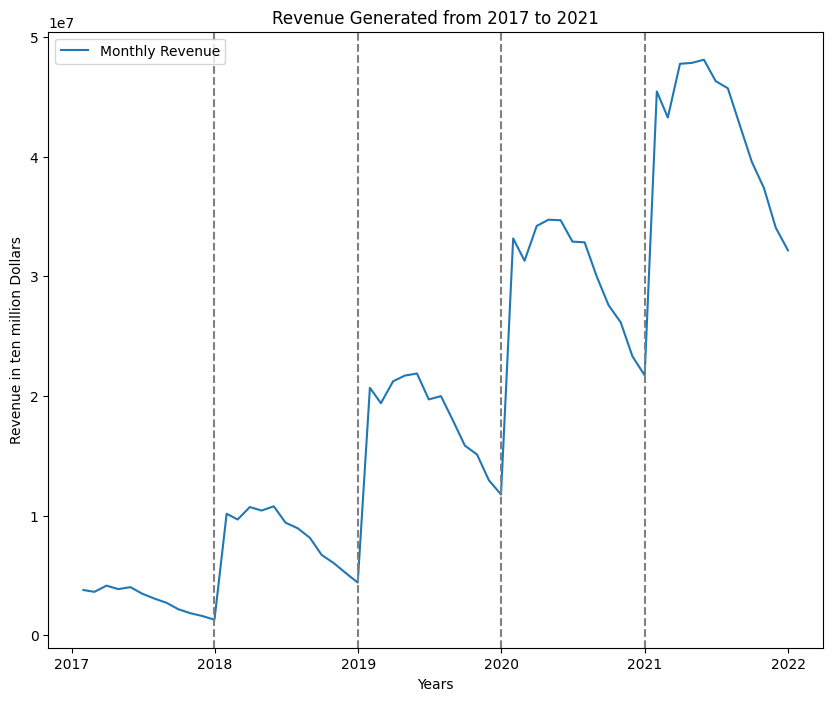

In [40]:
#create an axis object and a figure
fig, axis1 = plt.subplots(figsize =(10,8))

#plot the time series data
axis1.plot(total_month_rev.index, total_month_rev['Revenue'], label = 'Monthly Revenue')

#set axis labels
axis1.set_xlabel('Years')
axis1.set_ylabel('Revenue in ten million Dollars')
axis1.set_title('Revenue Generated from 2017 to 2021')
axis1.legend(loc= 'upper left')


#lines to observe trend
line_dates = pd.to_datetime(['2017-12-31', '2018-12-31', '2019-12-31','2020-12-31'])
for date in line_dates:
  axis1.axvline(x= date, color = 'gray', linestyle = 'dashed')
plt.show()

The plot above shows that it is seasonal and the seasonal flunctuation increases proportionally with an increase in the level of the series. This is observed from the bell like shape in the plot above. A multiplicative model is the appropriate model for this time series as multiplicative models are effective when the seasonal value changes over time.

In multiplicative decomposition, the time series data, y(t), is the multiplication of the decomposed components.


> y(t) = m(t) * s(t) * e(t)
<p> where:
<p> m(t) is the trend component
<p> s(t) is the seasonal component
<p> e(t) is the noise component


In [41]:
# get multiplicative decomposition component
decomposition = seasonal_decompose(total_month_rev[['Revenue']], model = 'multiplicative', period = 12)

Plot the results from decomposition


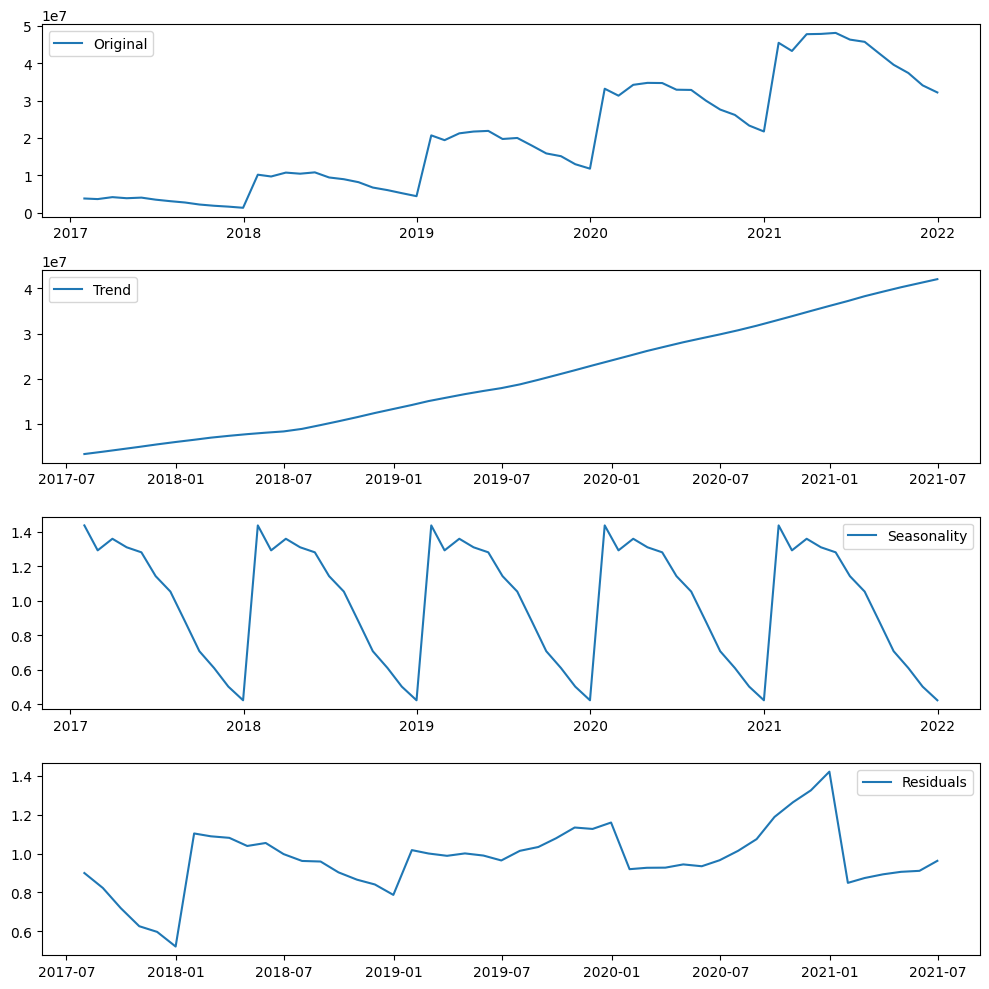

In [42]:

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(total_month_rev[['Revenue']], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


It should be noted that model building and further analysis need to be done on the deseasonalised data.

In [43]:
#obtain the deseasonalised date
deseasonal = (total_month_rev['Revenue'] / decomposition.seasonal).round()

deseasonal = pd.DataFrame(deseasonal, columns = ['d_Revenue'])
deseasonal.head()


,d_Revenue
2017-01-31,2633795.0
2017-02-28,2807939.0
2017-03-31,3051793.0
2017-04-30,2945050.0
2017-05-31,3139408.0


Split the data into trainset and test set for model building

In [44]:
#split the data into train and  test set
trainset1 = deseasonal[:-12]
testset1 = deseasonal[-12:]

#### Linear Regression in Decomposion technique

In [45]:
#xtrain is the range of number of occurence, ie 1-48
x_train = np.arange(1, 1 + len(trainset1)).reshape(-1,1)
#ytrain is the deseasonalized revenue value of the trainset
y_train = trainset1['d_Revenue']

#Linear regression model is built using xtrain and ytrain values
model = LinearRegression().fit(x_train, y_train)

In [46]:
#This linear regression model is used to predict the dseasonalised revenue for the testset
#x_test is the range of the number of occurence, from 49-60
x_test = np.arange(1 + len(trainset1), 1 +  len(trainset1) +len(testset1)).reshape(-1,1)
y_pred_des = model.predict(x_test)

The seasonal component is added to the predicted deseasonal revenue

In [47]:
y_pred = y_pred_des * decomposition.seasonal[-12:]

A plot to show the actual and forecasted values

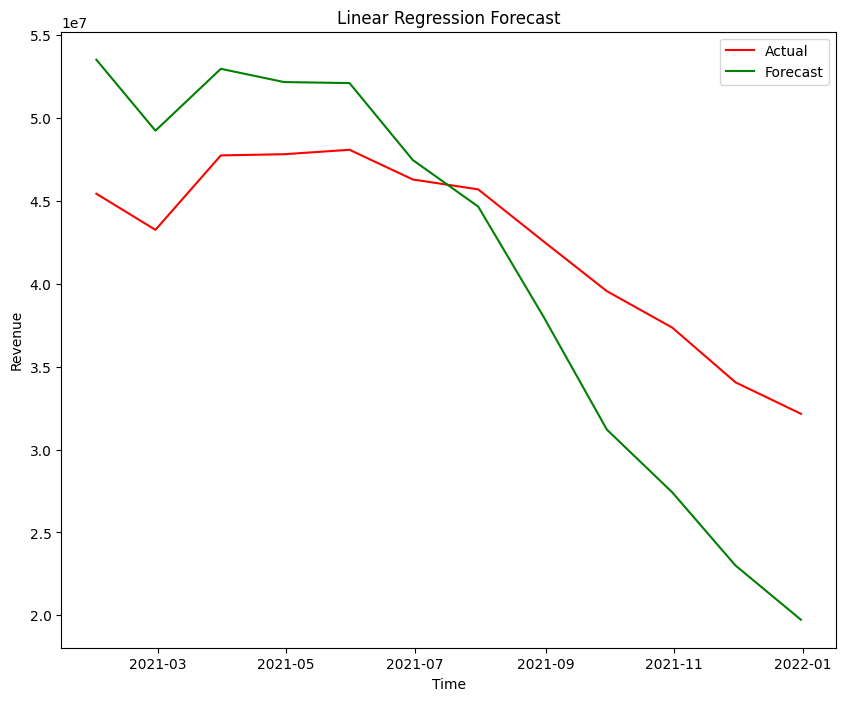

In [48]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(testset1.index, total_month_rev[-12:], color = 'red', label='Actual')
ax.plot(testset1.index, y_pred, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Revenue')
ax.set_title('Linear Regression Forecast')
ax.legend()
plt.show()

The performance of the model is inspected.

In [49]:
#function that checks the performance of models 
def perf_m (r,d, word=''):
  print(word)
  # Calculate MSE
  mse = mean_squared_error(r, d)
  print("MSE:", mse)

  # Calculate RMSE
  rmse = np.sqrt(mse)
  print("RMSE:", rmse)

  # Calculate MAE
  mae = mean_absolute_error(r, d)
  print("MAE:", mae,'\n')

In [50]:
linear_decomposition_performance = perf_m(total_month_rev['Revenue'][-12:], y_pred)
linear_decomposition_performance


MSE: 52645064268714.35
RMSE: 7255691.853208372
MAE: 6349500.261848393 



It should be noted that the performance of the model is not so good, but the forecasted value, followed the trend of the actual value. The forecasted value dipped when the actual value dipped and rose when the actual value rose. This is observed in the figure above.

#### Long Short-Term Memory (LSTM)

The deseasonalised data is scaled from 0-1.

In [351]:
#scale the deseasonal data
scaler = MinMaxScaler(feature_range = (0,5))
scaled_data = scaler.fit_transform(pd.DataFrame(deseasonal))

In [352]:
#the scaled data is split into trainset and testset
trainset2 = scaled_data[:-12]
testset2 = scaled_data[-12:]
testset2

array([[1.97260467],
       [2.09888999],
       [2.21102852],
       [2.30485136],
       [2.37568353],
       [2.57805831],
       [2.77360198],
       [3.11721368],
       [3.62708616],
       [3.9914675 ],
       [4.43948348],
       [5.        ]])

We are interested in predicting the revenue for a year, 12 months.

In [398]:
n_input = 20
n_features = 1
generator = TimeseriesGenerator(trainset2, trainset2, length = n_input, batch_size = 1)
generator

In [399]:
model = Sequential()
# model.add(LSTM(1, input_shape = (20, 1)))
model.add(LSTM(1,activation = 'tanh', input_shape = (20, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(generator, epochs = 200, batch_size = 2)

Epoch 1/200
28/28 [==============================] - 2s 9ms/step - loss: 2.4887
Epoch 2/200
28/28 [==============================] - 0s 9ms/step - loss: 2.3744
Epoch 3/200
28/28 [==============================] - 0s 10ms/step - loss: 2.2656
Epoch 4/200
28/28 [==============================] - 0s 9ms/step - loss: 2.1587
Epoch 5/200
28/28 [==============================] - 0s 10ms/step - loss: 2.0519
Epoch 6/200
28/28 [==============================] - 0s 8ms/step - loss: 1.9475
Epoch 7/200
28/28 [==============================] - 0s 8ms/step - loss: 1.8518
Epoch 8/200
28/28 [==============================] - 0s 12ms/step - loss: 1.7504
Epoch 9/200
28/28 [==============================] - 0s 12ms/step - loss: 1.6580
Epoch 10/200
28/28 [==============================] - 0s 12ms/step - loss: 1.5685
Epoch 11/200
28/28 [==============================] - 0s 14ms/step - loss: 1.4797
Epoch 12/200
28/28 [==============================] - 0s 15ms/step - loss: 1.4056
Epoch 13/200
28/28 [==========

In [284]:
# n_input = 4
# n_features = 1
# generator_test = TimeseriesGenerator(testset2, testset2, length = n_input, batch_size = 1)

In [400]:
test_prediction = []
first_eval_batch = trainset2[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(testset2)):
  current_pred = model.predict(current_batch)[0]

  test_prediction.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)


1/1 [==============================] - 0s 26ms/step


In [401]:
#y_pred_des_lstm = scaler.inverse_transform(model.predict_generator(generator_test))
y_pred_des_lstm = scaler.inverse_transform(test_prediction)
y_pred_des_lstm = pd.DataFrame(list(y_pred_des_lstm), columns = ['P_Revenue'])
y_pred_des_lstm = y_pred_des_lstm.set_index(decomposition.seasonal[-12:].index)
y_pred_des_lstm

,P_Revenue
2021-01-31,4.204333e+07
2021-02-28,4.218675e+07
2021-03-31,4.240752e+07
2021-04-30,4.256821e+07
2021-05-31,4.268541e+07
2021-06-30,4.277018e+07
2021-07-31,4.283132e+07
2021-08-31,4.287851e+07
2021-09-30,4.291362e+07
2021-10-31,4.295090e+07


The seasonal component is added to the predicted deseasonal revenue

In [402]:

y_pred_lstm = pd.DataFrame(y_pred_des_lstm['P_Revenue'] * decomposition.seasonal[-12:], columns = ['Revenue']).round()

In [403]:
y_pred_lstm

,Revenue
2021-01-31,60438009.0
2021-02-28,54534842.0
2021-03-31,57674048.0
2021-04-30,55788706.0
2021-05-31,54695890.0
2021-06-30,48890690.0
2021-07-31,45129101.0
2021-08-31,37688618.0
2021-09-30,30363343.0
2021-10-31,26192513.0


A plot to show the actual and forecasted values

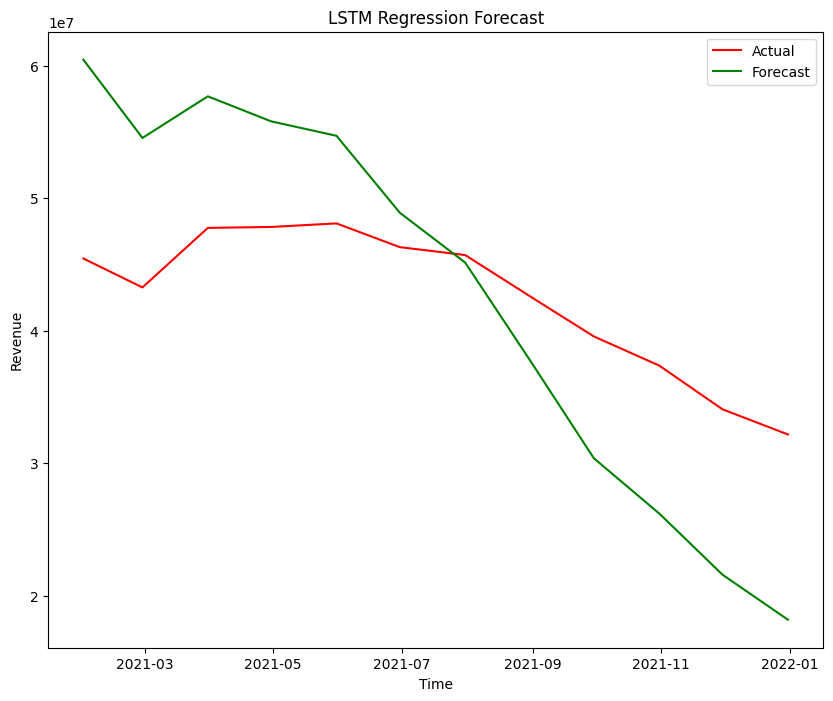

In [404]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(testset1.index, total_month_rev[-12:], color = 'red', label='Actual')
ax.plot(testset1.index, y_pred_lstm['Revenue'], color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Revenue')
ax.set_title('LSTM Regression Forecast')
ax.legend()
plt.show()

In [405]:
lstm_decomposition_performance = perf_m(total_month_rev['Revenue'][-12:], y_pred_lstm['Revenue'])
lstm_decomposition_performance


MSE: 95763467102672.75
RMSE: 9785881.007996814
MAE: 8803328.583333334 



##Long Short-Term Memory (LSTM)

In this section we will be using the LSTM model directly on our dataset without the use of decomposition method

In [487]:
df_lstm_dir = total_month_rev


In [489]:
#scale the data
scaler = MinMaxScaler(feature_range = (-1,1))
scaled_data2 = scaler.fit_transform(df_lstm_dir)

In [544]:
#the scaled data is split into trainset and testset
trainset3 = scaled_data2[:-12]
testset3 = scaled_data2[-12:]
testset3

array([[0.88667642],
       [0.79350603],
       [0.98552929],
       [0.98855703],
       [1.        ],
       [0.92343137],
       [0.89792168],
       [0.76367329],
       [0.63537884],
       [0.54134705],
       [0.40021492],
       [0.31914477]])

We will follow the same steps as above buit this time without deseasonalizing the data

In [585]:
n_input = 12
n_features = 1
generator2 = TimeseriesGenerator(trainset3, trainset3, length = n_input, batch_size = 1)


In [ ]:
model = Sequential()
# model.add(LSTM(1, input_shape = (24, 1)))
model.add(LSTM(132,activation = 'tanh', input_shape = (12, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(generator2, epochs = 1200, batch_size =2)

Epoch 1/1200
36/36 [==============================] - 3s 13ms/step - loss: 0.1038
Epoch 2/1200
36/36 [==============================] - 0s 13ms/step - loss: 0.0806
Epoch 3/1200
36/36 [==============================] - 0s 13ms/step - loss: 0.0754
Epoch 4/1200
36/36 [==============================] - 0s 13ms/step - loss: 0.0717
Epoch 5/1200
36/36 [==============================] - 0s 9ms/step - loss: 0.0776
Epoch 6/1200
36/36 [==============================] - 0s 9ms/step - loss: 0.0749
Epoch 7/1200
36/36 [==============================] - 0s 10ms/step - loss: 0.0700
Epoch 8/1200
36/36 [==============================] - 0s 9ms/step - loss: 0.0575
Epoch 9/1200
36/36 [==============================] - 0s 10ms/step - loss: 0.0583
Epoch 10/1200
36/36 [==============================] - 0s 10ms/step - loss: 0.0500
Epoch 11/1200
36/36 [==============================] - 0s 10ms/step - loss: 0.0351
Epoch 12/1200
36/36 [==============================] - 0s 9ms/step - loss: 0.0373
Epoch 13/1200
36/

In [587]:
test_prediction = []
first_eval_batch = trainset3[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(testset3)):
  current_pred = model.predict(current_batch)[0]

  test_prediction.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 50ms/step


In [588]:
y_pred_lstm = scaler.inverse_transform(test_prediction)
y_pred_lstm = pd.DataFrame(list(y_pred_lstm), columns = ['P_Revenue']).round()
y_pred_lstm = y_pred_lstm.set_index(total_month_rev[-12:].index)
y_pred_lstm

,P_Revenue
2021-01-31,21392495.0
2021-02-28,20162956.0
2021-03-31,19431441.0
2021-04-30,30453273.0
2021-05-31,34787512.0
2021-06-30,36105293.0
2021-07-31,36244959.0
2021-08-31,36082536.0
2021-09-30,35478695.0
2021-10-31,35130920.0


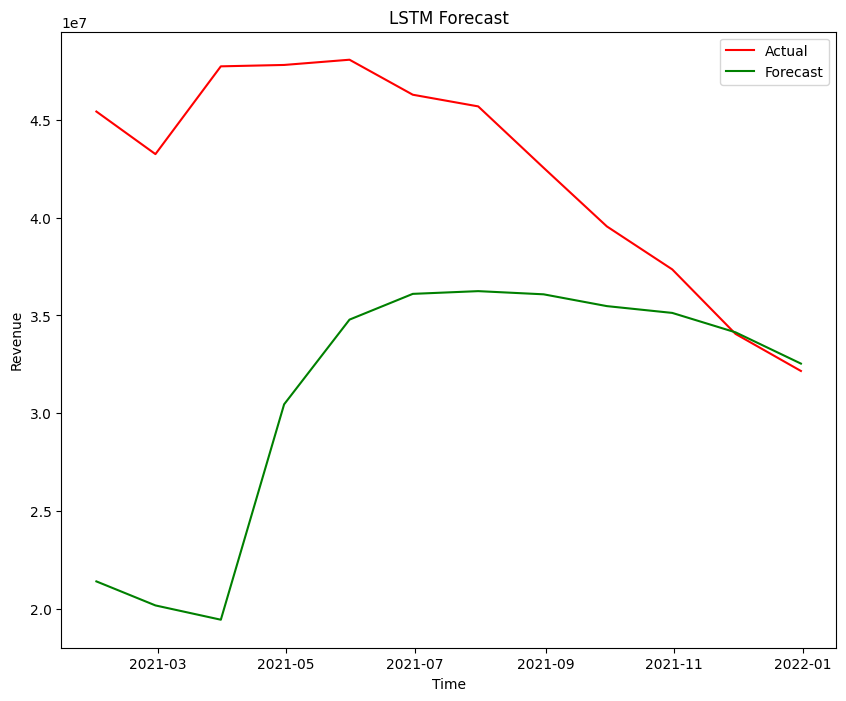

In [589]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(total_month_rev[-12:].index, total_month_rev[-12:], color = 'red', label='Actual')
ax.plot(total_month_rev[-12:].index, y_pred_lstm['P_Revenue'], color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Revenue')
ax.set_title('LSTM Forecast')
ax.legend()
plt.show()

In [590]:
lstm_decomposition_performance = perf_m(total_month_rev['Revenue'][-12:], y_pred_lstm['P_Revenue'])
lstm_decomposition_performance


MSE: 220708614582147.84
RMSE: 14856265.162622396
MAE: 11583360.0 

